# PORTFOLIO EVALUATOR

Evaluates portfolios, calculates performance metrics, and produces graphs for streamlit app.


In [102]:
# IMPORTS and DISPLAY options
import pandas as pd
from pathlib import Path
import numpy as np
import os, sys, json
import yfinance as yf
import shutil
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

DATA_DIR = Path.cwd() / "data"

### 1) Importing / Cleaning Data

In [103]:
# Change this path to your file
PORTFOLIO_CSV = DATA_DIR / "portfolio_weights.csv"  # columns: date, id, weight, stock_ret, sector, country, cap-size

In [104]:
# Change this path to your file
MKT_CSV = DATA_DIR / "MSCI_ind.csv"  # expects columns: year, month, rf, ret

In [105]:
RF_CSV = DATA_DIR / "mkt_ind.csv"

In [134]:
ME_TBL = DATA_DIR / "me_lnktbl.csv"

##### Load Portfolio

In [129]:
# Load portfolio CSV and prepare columns
def load_portfolio(csv_path: str) -> pd.DataFrame:
    """
    Load a monthly-rebalanced portfolio with columns:
      - date: month-end date (string or datetime)
      - id:   security identifier (string/int)
      - weight: portfolio weight at 'date' (should sum to 1 per month)
      - stock_ret: realized return over NEXT month for that id (aligned so that
                   if date = 2005-01-31, this is Feb return)

    Returns a normalized DataFrame with:
      - date (pd.Timestamp, normalized to month-end)
      - year_month (str, 'YYYY-MM')
      - id (str)
      - weight (float)
      - stock_ret (float or NaN)
    """
    df = pd.read_csv(csv_path)

    required = {"date", "id", "weight", "stock_ret"}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")

    # Parse date and coerce types
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    # Safety: force to period month then back to month-end Timestamp
    df["date"] = df["date"].dt.to_period("M").dt.to_timestamp("M")
    df["year_month"] = df["date"].dt.to_period("M").astype(str)

    # Normalize types
    df["id"] = df["id"].astype(str)
    df["weight"] = pd.to_numeric(df["weight"], errors="coerce")
    df["stock_ret"] = pd.to_numeric(df["stock_ret"], errors="coerce")

    # Sort for consistency
    df = df.sort_values(["date", "id"]).reset_index(drop=True)
    return df

In [130]:
portfolio_df = load_portfolio(PORTFOLIO_CSV)
portfolio_df.head()

,id,date,weight,stock_ret,long_gross,short_gross,year_month
0,comp_002137_01C,2017-02-28,0.006681,-0.027998,0.855023,0.297324,2017-02
1,comp_002408_01C,2017-02-28,0.004840,-0.020903,0.855023,0.297324,2017-02
2,comp_005770_03C,2017-02-28,-0.005005,0.214355,0.855023,0.297324,2017-02
3,comp_006135_01C,2017-02-28,-0.002974,0.003213,0.855023,0.297324,2017-02
4,comp_006672_01C,2017-02-28,0.011550,-0.106742,0.855023,0.297324,2017-02


In [135]:
def table_verification(portfolio_df, me_path):
    me_table = pd.read_csv(me_path)
    # Convert IDs to strings (just in case)
    portfolio_ids = set(portfolio_df["id"].astype(str))
    me_ids = set(me_table["id"].astype(str))

    # Find which portfolio IDs are not in ME_TABL
    missing_ids = portfolio_ids - me_ids

    if len(missing_ids) == 0:
        print("✅ All portfolio IDs are present in ME_TABL.")
    else:
        print(f"⚠️ {len(missing_ids)} IDs from portfolio_df are missing in ME_TABL.")
        print("Here are a few examples:")
        print(list(missing_ids)[:10])

    return missing_ids

missing = table_verification(portfolio_df, ME_TBL)

✅ All portfolio IDs are present in ME_TABL.


In [136]:
def attach_size_class(portfolio_df, me_path):
    me_table = pd.read_csv(me_path)
    # keep one size_class per id (in case link table has dupes)
    size_lookup = (
        me_table[['id', 'size_class']]
        .dropna(subset=['size_class'])
        .drop_duplicates(subset='id', keep='last')
    )

    # be strict about types
    portfolio_df = portfolio_df.copy()
    portfolio_df['id'] = portfolio_df['id'].astype(str)
    size_lookup['id'] = size_lookup['id'].astype(str)

    # many portfolio rows -> one size_class per id
    out = portfolio_df.merge(
        size_lookup,
        on='id',
        how='left',
        validate='many_to_one'
    )

    # quick sanity ping
    missing = out['size_class'].isna().sum()
    if missing:
        print(f"Warning: {missing} portfolio rows have no size_class. Fix your link table.")
    else:
        print("All rows tagged with size_class. Gold star.")

    return out


In [145]:
portfolio_df = attach_size_class(portfolio_df, ME_TBL)
portfolio_df.head(10)

All rows tagged with size_class. Gold star.


,id,date,weight,stock_ret,long_gross,short_gross,year_month,size_class
0,comp_002137_01C,2017-02-28,0.006681,-0.027998,0.855023,0.297324,2017-02,large
1,comp_002408_01C,2017-02-28,0.004840,-0.020903,0.855023,0.297324,2017-02,large
2,comp_005770_03C,2017-02-28,-0.005005,0.214355,0.855023,0.297324,2017-02,small
3,comp_006135_01C,2017-02-28,-0.002974,0.003213,0.855023,0.297324,2017-02,large
4,comp_006672_01C,2017-02-28,0.011550,-0.106742,0.855023,0.297324,2017-02,small
5,comp_009215_01C,2017-02-28,0.003057,-0.027948,0.855023,0.297324,2017-02,small
6,comp_010671_01C,2017-02-28,-0.002973,-0.021209,0.855023,0.297324,2017-02,large
7,comp_011443_01C,2017-02-28,0.009532,-0.013082,0.855023,0.297324,2017-02,large
8,comp_011787_01C,2017-02-28,-0.005026,-0.116444,0.855023,0.297324,2017-02,small
9,comp_013992_01C,2017-02-28,0.010225,-0.016908,0.855023,0.297324,2017-02,small


In [ ]:
def append_cash_position(portfolio_df):
    df = portfolio_df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # find unique months
    monthly_cash = []
    for date, g in df.groupby('date'):
        lg = g['long_gross'].iloc[0]
        sg = g['short_gross'].iloc[0]

        if (lg - 1) < sg:
            # residual cash weight (positive means cash held)
            cash_weight = 1 - (lg - sg)
            monthly_cash.append({
                'id': 'cash holding',
                'date': date,
                'weight': cash_weight,
                'stock_ret': 0.0,   # assume risk-free zero return
                'long_gross': lg,
                'short_gross': sg
            })

    if not monthly_cash:
        print("No months triggered a cash position.")
        return df

    cash_df = pd.DataFrame(monthly_cash)
    result = pd.concat([df, cash_df], ignore_index=True)
    print(f"Added {len(cash_df)} monthly cash rows.")
    return result

In [146]:
portfolio_df = append_cash_position(portfolio_df)
portfolio_df

Added 89 monthly cash rows.


,id,date,weight,stock_ret,long_gross,short_gross,year_month,size_class
0,comp_002137_01C,2017-02-28,0.006681,-0.027998,0.855023,0.297324,2017-02,large
1,comp_002408_01C,2017-02-28,0.004840,-0.020903,0.855023,0.297324,2017-02,large
2,comp_005770_03C,2017-02-28,-0.005005,0.214355,0.855023,0.297324,2017-02,small
3,comp_006135_01C,2017-02-28,-0.002974,0.003213,0.855023,0.297324,2017-02,large
4,comp_006672_01C,2017-02-28,0.011550,-0.106742,0.855023,0.297324,2017-02,small
...,...,...,...,...,...,...,...,...
16146,CASH,2024-04-30,0.301589,0.000000,1.166727,0.468316,NaN,NaN
16147,CASH,2024-05-31,0.634753,0.000000,0.721554,0.356307,NaN,NaN
16148,CASH,2024-06-30,0.516019,0.000000,0.821271,0.337290,NaN,NaN
16149,CASH,2024-07-31,0.490063,0.000000,0.806693,0.296756,NaN,NaN


In [144]:
test.groupby('date')['weight'].sum()

date
2017-02-28    1.0
2017-03-31    1.0
2017-04-30    1.0
2017-05-31    1.0
2017-06-30    1.0
             ... 
2024-04-30    1.0
2024-05-31    1.0
2024-06-30    1.0
2024-07-31    1.0
2024-08-31    1.0
Name: weight, Length: 91, dtype: float64

In [109]:
# Check if valid PF: Validate monthly weight sums

def _is_valid_portfolio(
    portfolio_df: pd.DataFrame,
    *,
    weight_col: str = "weight",
    date_col: str = "year_month",
    net_target: float = 1.0,     # 150/50 => net ≈ +1
    long_cap: float = 1.5,    # sum of longs must be ≤ this
    short_floor: float = -0.5,  # sum of shorts must be ≥ this
    tol: float = 1e-6
):
    """
     Validate monthly sums for a 150/50 mandate with inequality checks:
      - |net_sum - net_target| ≤ tol
      - long_sum ≤ long_cap + tol
      - short_sum ≥ short_floor - tol

    Returns
    -------
    valid : bool
        True if all months meet targets within tolerance.
    invalid_rows : pd.DataFrame
        Rows for months that fail any check, with diagnostics.
    """

    if date_col not in portfolio_df.columns:
        raise KeyError(f"Missing '{date_col}' in portfolio_df")
    if weight_col not in portfolio_df.columns:
        raise KeyError(f"Missing '{weight_col}' in portfolio_df")
    
    # Aggregate by month
    grp = (
        portfolio_df
        .groupby(date_col)
        .agg(
            long_sum=(weight_col, lambda x: x[x > 0].sum()),
            short_sum=(weight_col, lambda x: x[x < 0].sum()),
            net_sum=(weight_col, "sum"),
        )
        .reset_index()
    )
    
    # Per-target checks with tolerance
    pass_net   = (grp["net_sum"] - net_target).abs() <= tol
    pass_long  = grp["long_sum"] <= (long_cap + tol)
    pass_short = grp["short_sum"] >= (short_floor - tol)

    grp["within_targets"] = pass_net & pass_long & pass_short

    # Minimal failure report
    invalid_cols = [date_col, "net_sum", "long_sum", "short_sum", "within_targets"]
    invalid_rows = grp.loc[~grp["within_targets"], invalid_cols].sort_values(by=date_col)

    all_valid = invalid_rows.empty
    return all_valid, invalid_rows

ok, bad = _is_valid_portfolio(portfolio_df)

print("Portfolio valid?", ok)
if not ok:
    print("Invalid months:")
    display(bad)

Portfolio valid? False
Invalid months:


,year_month,net_sum,long_sum,short_sum,within_targets
0,2017-02,0.557700,0.855023,-0.297324,False
1,2017-03,0.588154,0.876436,-0.288283,False
2,2017-04,0.601432,0.885773,-0.284340,False
3,2017-05,0.583212,0.872961,-0.289750,False
4,2017-06,0.578946,0.869962,-0.291016,False
...,...,...,...,...,...
86,2024-04,0.698411,1.166727,-0.468316,False
87,2024-05,0.365247,0.721554,-0.356307,False
88,2024-06,0.483981,0.821271,-0.337290,False
89,2024-07,0.509937,0.806693,-0.296756,False


##### Market Return

In [110]:
# Load Market CSV and prepare Monthly Market Return
def load_mkt_ret(
    mkt_csv_path: str = MKT_CSV,
    date_col: str = "date",
) -> pd.DataFrame:
    
    """Load market returns from CSV"""
    
    mk = pd.read_csv(mkt_csv_path)

    # Convert date to datetime
    mk[date_col] = pd.to_datetime(mk[date_col])
    mk["year_month"] = mk[date_col].dt.to_period("M")
    mk.rename(columns={"return":"ret"}, inplace=True)
    
     # Return as Series with year_month index
    rm = (
        mk[["year_month", "ret"]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")["ret"]
        .sort_index()
    )
    return rm

In [111]:
mkt_ret_df = load_mkt_ret()
mkt_ret_df.tail()

year_month
2025-05    0.056889
2025-06    0.042180
2025-07    0.012317
2025-08    0.024945
2025-09    0.030875
Freq: M, Name: ret, dtype: float64

##### RF Return

In [112]:
# Load Market CSV and prepare Monthly Riskless Return
def load_rf_ret(
    mkt_csv_path: str = RF_CSV,
    rf_col: str = "rf",
    year_col: str = "year",
    month_col: str = "month",
) -> pd.DataFrame:
    mk = pd.read_csv(mkt_csv_path)
    for c in (year_col, month_col, rf_col):
        if c not in mk.columns:
            raise KeyError(
                f"CSV must contain '{year_col}', '{month_col}', and '{rf_col}'. "
                f"Got: {mk.columns.tolist()}"
            )
        
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int),
        month=mk[month_col].astype(int),
        freq="M",
    )
    
    rf = (
        mk[["year_month", rf_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[rf_col]
        .astype(float)
        .sort_index()
    )
    return rf

In [113]:
rf_ret_df = load_rf_ret()
rf_ret_df.head()

year_month
2005-01    0.0016
2005-02    0.0016
2005-03    0.0021
2005-04    0.0021
2005-05    0.0024
Freq: M, Name: rf, dtype: float64

##### Portfolio Return
Gross, including rf for cash holdings...

In [127]:
def load_prtf_ret(
    port_csv_path: str = PORTFOLIO_CSV,
    *,
    date_col: str = "year_month",
    weight_col: str = "weight",
    ret_col: str = "stock_ret",
) -> pd.DataFrame:
    df = load_portfolio(port_csv_path)

    monthly_returns = (
        df.dropna(subset=[ret_col])
        .assign(prod=lambda d: d[weight_col] * d[ret_col])
        .groupby(date_col, as_index=False)['prod']
        .sum()
        .rename(columns={'prod': 'pf_monthly_ret'})
    )

    dt = pd.to_datetime(monthly_returns[date_col] + "-01")
    monthly_returns[date_col] = dt.dt.strftime("%Y-%m")
    return monthly_returns

In [128]:
prtf_ret_df = load_prtf_ret()
prtf_ret_df.head()

,year_month,pf_monthly_ret
0,2017-02,0.010327
1,2017-03,0.029520
2,2017-04,0.034626
3,2017-05,-0.025722
4,2017-06,0.029196


##### Net Ptf Return


In [ ]:


def net_return(

)

### 2) Evaluation Functions:

In [117]:
# Risk / Return Helpers (annualized where relevant)
def cagr() -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()
    
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.empty:
        return np.nan
    
    total_growth = (1.0 + r).prod()
    years = len(r) / 12.0
    if years <= 0:
        return np.nan
    
    return float(total_growth ** (1.0 / years) - 1.0)

def std() -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.size == 0:
        return np.nan
    
    std_m = r.std(ddof=1)
    if np.isnan(std_m):
        return np.nan
    
    return float(std_m * np.sqrt(12.0))

def sharpe_ratio(
    ret_rf: pd.DataFrame,
    annualize: bool = True,
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    r_idx = pd.PeriodIndex(m["year_month"], freq="M")
    r = pd.Series(r.values, index=r_idx).dropna().sort_index()
    if r.size < 2:
        return np.nan

    rf = ret_rf

    # Excess returns aligned
    common = r.index.intersection(rf.index)
    if len(common) < 2:
        return np.nan
    ex = (r.loc[common] - rf.loc[common]).dropna()
    if ex.size < 2:
        return np.nan

    mu_m = ex.mean()
    sd_m = ex.std(ddof=1)
    if sd_m == 0 or np.isnan(sd_m):
        return np.nan

    sr = mu_m / sd_m
    return float(sr * np.sqrt(12.0)) if annualize else float(sr)

def active_alpha(
    ret_mkt: pd.DataFrame,
    annualize: bool = True,   
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.empty:
        print("AL: Error 0")
        return np.nan
    
    rm = ret_mkt

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        print("AL: Error 1")
        return np.nan

    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.empty:
        print("AL: Error 2")
        return np.nan
    return float(active.mean() * 12.0) if annualize else float(active.mean())
    

def tracking_error(
    ret_mkt: pd.DataFrame,
    annualize: bool = True,
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.empty:
        print("TE: Error 0")
        return np.nan
    
    rm = ret_mkt

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        print("TE: Error 1")
        return np.nan

    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.empty:
        print("TE: Error 2")
        return np.nan

    te_m = active.std(ddof=1)
    return float(te_m * np.sqrt(12.0)) if annualize else float(te_m)



def information_ratio(
    ret_mkt: pd.DataFrame,
) -> float:
    # Portfolio monthly returns
    m = load_prtf_ret()

    rp = pd.to_numeric(m["pf_monthly_ret"], errors="coerce")
    rp.index = pd.PeriodIndex(m["year_month"], freq="M")
    rp = rp.sort_index().dropna()
    if rp.size < 2:
        print("IR: Error 0")
        return np.nan
    
    rm = ret_mkt

    idx = rp.index.intersection(rm.index)
    if len(idx) < 2:
        return np.nan
    active = (rp.loc[idx] - rm.loc[idx]).dropna()
    if active.size < 2:
        print("IR: Error 1")
        return np.nan

    te_ann = tracking_error(ret_mkt, annualize=True)

    if te_ann is None or np.isnan(te_ann) or te_ann == 0:
        print("IR: Error 2")
        return np.nan

    mu_active_ann = float(active.mean() * 12.0)
    return mu_active_ann / te_ann


In [118]:
# Drawdown, Turnover, and Summary Stats
def drawdown_series() -> pd.Series:
    
    # Portfolio monthly returns
    m = load_prtf_ret()
    
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()
    if r.empty:
        return pd.Series(dtype=float, name="drawdown")

    idx = pd.PeriodIndex(m.loc[r.index, "year_month"], freq="M")
    r = pd.Series(r.values, index=idx).sort_index()

    cum = (1.0 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0

    dd = dd.copy()
    dd.index = dd.index.astype(str)
    dd.name = "drawdown"
    return dd
    
def turnover(
    ptf_df: pd.DataFrame,
    date_col: str = "year_month",
    id_col: str = "id",
    w_col: str = "weight",
    as_string_months: bool = False,
    return_panel: bool = False,
) -> pd.DataFrame:
    """
    Compute monthly portfolio turnover with disappearing/appearing names handled.
    Turnover_t = 0.5 * sum_i |w_{i,t} - w_{i,t-1}|
    Missing names are treated as 0 weight.

    Parameters
    ----------
    ptf_df : DataFrame with columns [date_col, id_col, w_col]
    return_panel : bool
        If True, also return the wide month×id panel used for turnover.
    as_string_months : bool
        If True, converts month Periods to 'YYYY-MM' strings for output.

    Returns
    -------
    turnover_df : DataFrame with [date_col, 'turnover']
    panel (optional) : DataFrame with months as rows, ids as columns (weights with 0 fill)
    """

    # Step 1: Normalize months
    df = ptf_df[[date_col, id_col, w_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col]).dt.to_period("M")

    # Step 2: Build the month × id panel (0 where stock absent)
    panel = (
        df.pivot_table(
            index=date_col,
            columns=id_col,
            values=w_col,
            aggfunc="sum",
            fill_value=0.0,
        )
        .sort_index()
    )

    # Step 3: Compute month-to-month absolute change (L1)
    turnover_series = panel.diff().abs().sum(axis=1) / 2.0
    turnover_series = turnover_series.dropna()
    turnover_series.name = "turnover"

    # Step 4: Format output table
    turnover_df = turnover_series.reset_index()
    turnover_df.columns = [date_col, "turnover"]
    if as_string_months and isinstance(turnover_df[date_col].dtype, pd.PeriodDtype):
        turnover_df[date_col] = turnover_df[date_col].astype(str)

    return (turnover_df, panel) if return_panel else turnover_df

def summary_statistics(
    ret_mkt: pd.DataFrame,
    ret_rf: pd.DataFrame,
) -> pd.DataFrame:
    m = load_prtf_ret()
    r = pd.to_numeric(m["pf_monthly_ret"], errors="coerce").dropna()

    max_one_m_loss = float(r.min()) if not r.empty else np.nan
    dd = drawdown_series()
    max_drawdown = float(dd.min()) if dd.size else np.nan
    to_df = turnover(load_portfolio(PORTFOLIO_CSV))
    avg_turnover = float(to_df["turnover"].mean()) if not to_df.empty else np.nan

    cagr_val   = cagr()
    std_val    = std()
    sharpe_val = sharpe_ratio(ret_rf)
    alpha_val  = active_alpha(ret_mkt)
    ir_val     = information_ratio(ret_mkt)

    stats = pd.DataFrame(
        {
            "metric": [
                "CAGR",
                "STD",
                "Sharpe",
                "IR",
                "Alpha",
                "Max Drawdown",
                "Max_one_month_loss",
                "Avg_Turnover",
            ],
            "value": [
                cagr_val,
                std_val,
                sharpe_val,
                ir_val,
                alpha_val,
                max_drawdown,
                max_one_m_loss,
                avg_turnover,
            ],
        }
    )
    return stats


### 3) Calculate Results

In [119]:
# Calculate Stats
stats = summary_statistics(
    load_mkt_ret(), 
    load_rf_ret()
)

stats


,metric,value
0,CAGR,0.136688
1,STD,0.130300
2,Sharpe,0.899725
3,IR,0.195434
4,Alpha,0.029711
5,Max Drawdown,-0.148140
6,Max_one_month_loss,-0.093757
7,Avg_Turnover,0.720923


### 4) Export Data / Results

In [120]:
# EXPORT PORTFOLIO RETURNS
portfolio_file = "outputs/prtf_ret.csv"

# Standardize Naming
prtf_df = prtf_ret_df.rename(columns={"year_month": "date", "pf_monthly_ret": "ret"}).copy()

prtf_df.to_csv(portfolio_file, index=False)

In [121]:
# EXPORT MARKET RETURNS
market_file = "outputs/mkt_ret.csv"

# Match market returns timeframe to portfolio returns
start_date = prtf_df["date"].min()
end_date = prtf_df["date"].max()

# Filter market returns to start from 2015-01 and rename 
mkt_df = (mkt_ret_df
          .loc[start_date:end_date]
          .copy()
          .reset_index()
          .rename(columns={"year_month": "date"})
)

mkt_df.to_csv(market_file, index=False)

In [122]:
# Turn table into Json
stats_dict = {
    row["metric"]: row["value"]
    for _, row in stats.iterrows()
}

main_file = "outputs/metrics.json"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_file = f"outputs/backups/t_metrics_{timestamp}.json"

with open(main_file, "w") as f:
    json.dump(stats_dict, f, indent=4)

print(f"✅ Latest metrics saved to {main_file}")

shutil.copy(main_file, backup_file)

print(f"🗂️ Backup created: {backup_file}")

stats_dict

✅ Latest metrics saved to outputs/metrics.json
🗂️ Backup created: outputs/backups/t_metrics_20251105_213102.json


{'CAGR': 0.1366883422142111,
 'STD': 0.13029987844741875,
 'Sharpe': 0.8997252945922244,
 'IR': 0.19543439532486942,
 'Alpha': 0.029710840725972222,
 'Max Drawdown': -0.14813972394520702,
 'Max_one_month_loss': -0.09375665421574159,
 'Avg_Turnover': 0.7209232166595265}

In [123]:
# def to_cummulative(
#     ptf_df: pd.DataFrame,
#     start: float,
# ) -> pd.DataFrame:
#     """
#     Calculate Cummulative PnL
#     """
    
    
    

In [124]:
# ---------- THEME ----------
BRAND = {
    "bg": "white",
    "fg": "#003366",        # deep navy for text/axes
    "grid": "#cce0ff",      # very light blue for gridlines

    # Line colors
    "portfolio": "#e64f3c",       # strong orange/red
    "market":    "#007acc",       # bright blue

    # Fill colors (lighter accents)
    "drawdown_fill_pf": "#f28c3c",   # lighter orange
    "drawdown_fill_mkt": "#66a3ff",  # light blue
}


plt.rcParams.update({
    "figure.figsize": (10, 4.5),
    "figure.facecolor": BRAND["bg"],
    "axes.facecolor": BRAND["bg"],
    "axes.edgecolor": BRAND["fg"],
    "axes.labelcolor": BRAND["fg"],
    "axes.titlecolor": BRAND["fg"],
    "xtick.color": BRAND["fg"],
    "ytick.color": BRAND["fg"],
    "grid.color": BRAND["grid"],
    "grid.linestyle": "-",
    "grid.alpha": 0.6,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlepad": 10,
    "axes.titleweight": "semibold",
    "legend.frameon": False,
    "legend.fontsize": 11,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

def _nicely_format_dates(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(6,)))
    ax.grid(True, which="major")
    ax.grid(True, which="minor", axis="x", alpha=0.15)

def _end_label(ax, x, y, label, color, offset=5):
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(offset, 0),
        textcoords="offset points",
        va="center",
        ha="left",
        fontsize=11,
        color=color,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.85),
    )

def _to_ts_index(r_period_idx: pd.PeriodIndex) -> pd.DatetimeIndex:
    return r_period_idx.to_timestamp("M")

# ---------- LOAD MARKET RETURNS ----------
def load_market_returns(
    mkt_csv_path: str,
    year_col: str = "year",
    month_col: str = "month",
    ret_col: str = "ret",
) -> pd.Series:
    mk = pd.read_csv(mkt_csv_path)
    mk["year_month"] = pd.PeriodIndex.from_fields(
        year=mk[year_col].astype(int), month=mk[month_col].astype(int), freq="M"
    )
    r_mkt = (
        mk[["year_month", ret_col]]
        .dropna()
        .drop_duplicates(subset=["year_month"])
        .set_index("year_month")[ret_col]
        .astype(float)
        .sort_index()
    )
    return r_mkt

# ---------- PLOTTING: CUMULATIVE ----------

def plot_cumulative_pretty(
    r_pf: pd.Series,             # monthly portfolio returns (PeriodIndex 'M')
    r_mkt: pd.Series,            # monthly market returns   (PeriodIndex 'M')
    *,
    title: str = "Cumulative Return (Monthly, %)",
    save_path: str | None = None
):
    # align
    common = r_pf.index.intersection(r_mkt.index)
    rpf, rmk = r_pf.loc[common], r_mkt.loc[common]

    # cumulative growth → convert to cumulative wealth
    cum_pf  = (1 + rpf).cumprod() - 1
    cum_mkt = (1 + rmk).cumprod() - 1

    idx_ts = _to_ts_index(common)
    cum_pf.index, cum_mkt.index = idx_ts, idx_ts

    fig, ax = plt.subplots()
    l1, = ax.plot(cum_pf, color=BRAND["portfolio"], linewidth=2.4, label="Portfolio")
    l2, = ax.plot(cum_mkt, color=BRAND["market"], linewidth=2.4, label="MSCI World Index")

    _nicely_format_dates(ax)
    ax.set_title(title)
    ax.set_ylabel("Cumulative Return (%)")
    ax.set_xlabel("Date")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # values in [0,1] → show as %

    # end labels as percentages
    _end_label(ax, cum_pf.index[-1], cum_pf.iloc[-1],
               f"{cum_pf.iloc[-1]*100:.1f}%", BRAND["portfolio"])
    _end_label(ax, cum_mkt.index[-1], cum_mkt.iloc[-1],
               f"{cum_mkt.iloc[-1]*100:.1f}%", BRAND["market"])

    ax.legend(loc="upper left")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# ---------- PLOTTING: DRAWDOWN ----------
def plot_drawdown_pretty(
    r_pf: pd.Series,
    r_mkt: pd.Series,
    *,
    title: str = "Drawdown (Monthly)",
    save_path: str | None = None
):
    common = r_pf.index.intersection(r_mkt.index)
    rpf, rmk = r_pf.loc[common], r_mkt.loc[common]

    def dd_from_r(r: pd.Series) -> pd.Series:
        cg = (1 + r).cumprod()
        peak = cg.cummax()
        return cg / peak - 1.0

    dd_pf  = dd_from_r(rpf)
    dd_mkt = dd_from_r(rmk)

    idx_ts = _to_ts_index(common)
    dd_pf.index, dd_mkt.index = idx_ts, idx_ts

    fig, ax = plt.subplots(figsize=(10, 3.8))
    # filled areas for punchier visuals
    ax.fill_between(dd_pf.index, dd_pf, 0, color=BRAND["drawdown_fill_pf"], alpha=0.18, label="Portfolio")
    ax.plot(dd_pf, color=BRAND["portfolio"], linewidth=2.0)
    ax.fill_between(dd_mkt.index, dd_mkt, 0, color=BRAND["drawdown_fill_mkt"], alpha=0.14, label="S&P 500")
    ax.plot(dd_mkt, color=BRAND["market"], linewidth=2.0)

    _nicely_format_dates(ax)
    ax.set_title(title)
    ax.set_ylabel("Drawdown (%)")
    ax.set_xlabel("Date")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # values in [-1, 0]
    ax.legend(loc="lower left")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


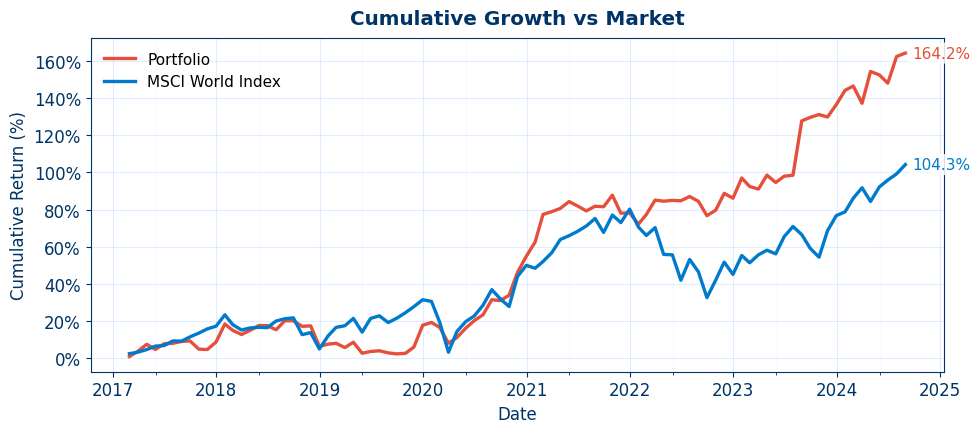

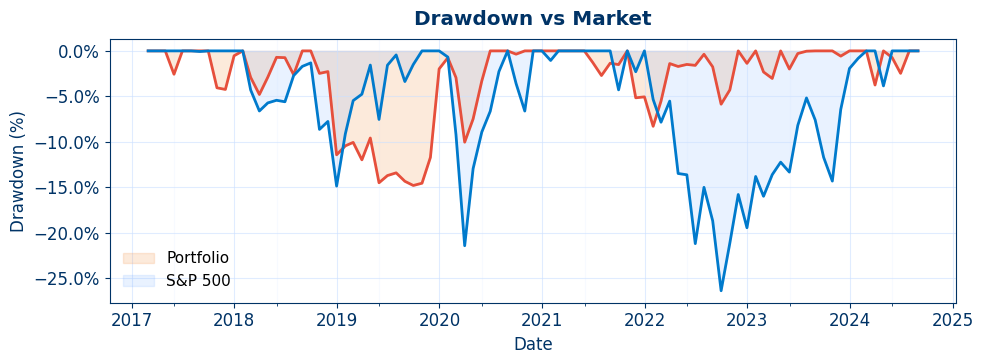

In [125]:
m = load_prtf_ret()
r_pf = pd.Series(
    pd.to_numeric(m["pf_monthly_ret"], errors="coerce").values,
    index=pd.PeriodIndex(m["year_month"], freq="M"),
).dropna().sort_index()

r_mkt = load_mkt_ret()

plot_cumulative_pretty(r_pf, r_mkt, title="Cumulative Growth vs Market")
plot_drawdown_pretty(r_pf, r_mkt, title="Drawdown vs Market")

# Save high-DPI images for slides:
#plot_cumulative_pretty(r_pf, r_mkt, title="Portfolio vs S&P500", save_path="cum_indexed.png")
#plot_drawdown_pretty(r_pf, r_mkt, title="Drawdown vs S&P500", save_path="drawdown.png")
